# Pykan tests Classification with pykan
Code taken based on https://github.com/KindXiaoming/pykan/tree/master/tutorials/Example
using Example_4_classification.ipynb.

To run this model,  it is needed to clone the pykan GitHub, cover requirements. The in can be run.

## Regression - Diabetes dataset

Let's first treat the problem as a regression problem (output dimension = 1, MSE loss). 

In [10]:
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np

# Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Cargar dataset de diabetes
data = load_diabetes()
X = data.data  # 10 atributos
y = data.target.reshape(-1, 1)  # Regresión: valores continuos

# Normalización (opcional pero recomendable)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# Dividir en entrenamiento y prueba
train_input, test_input, train_label, test_label = train_test_split(X, y, test_size=0.3, random_state=42)

# Convertir a tensores y enviar a dispositivo
dtype = torch.get_default_dtype()
dataset = {}
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(dtype).to(device)

# Visualización de una proyección PCA opcional
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# X_proj = pca.fit_transform(train_input)
# plt.scatter(X_proj[:, 0], X_proj[:, 1], c=train_label[:, 0])
# plt.show()

# Definir modelo con arquitectura [10,2,1]
model = KAN(width=[10, 2, 1], grid=3, k=3, device=device)

# Métricas

def train_rmse():
    y_pred = model(dataset['train_input'])
    mse = torch.mean((y_pred - dataset['train_label'])**2)
    return torch.sqrt(mse)

def test_rmse():
    y_pred = model(dataset['test_input'])
    mse = torch.mean((y_pred - dataset['test_label'])**2)
    return torch.sqrt(mse)

def train_loss():
    return torch.mean((model(dataset['train_input']) - dataset['train_label'])**2)

def test_loss():
    return torch.mean((model(dataset['test_input']) - dataset['test_label'])**2)


# Entrenar
results = model.fit(dataset, opt="Adam", steps=50, metrics=(train_loss, test_loss, train_rmse, test_rmse))

# Mostrar pérdida final (denormalizada si se desea)
results['train_loss'][-1], results['test_loss'][-1]


print("train_loss:", len(results['train_loss']))
print("test_loss:", len(results['test_loss']))
print("train_acc:", len(results['train_rmse']))
print("test_acc:", len(results['test_rmse']))


import pandas as pd

# Convertir resultados a DataFrame
loss_table = pd.DataFrame({
    'step': list(range(1, len(results['train_rmse']) + 1)),
    'train_loss': results['train_loss'][::2],
    'test_loss': results['test_loss'][::2],
    'train_rmse': results['train_rmse'],   
    'test_rmse': results['test_rmse']
})

# Mostrar primeras filas
print(loss_table.head())

# Guardar como CSV si lo deseas
loss_table.to_csv("Liu_KAN_diabetes_10-2-1.csv", index=False)


cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.85e-01 | test_loss: 7.08e-01 | reg: 1.05e+02 | : 100%|█| 50/50 [00:01<00:00, 29.91it


saving model version 0.1
train_loss: 100
test_loss: 100
train_acc: 50
test_acc: 50
   step  train_loss  test_loss  train_rmse  test_rmse
0     1   43.527851  33.225708    6.597564   5.764174
1     2    1.037220   0.912739    1.018440   0.955374
2     3    1.037295   0.913045    1.018477   0.955534
3     4    1.037338   0.913174    1.018498   0.955601
4     5    1.037351   0.913201    1.018505   0.955615


## Classification - Iris dataset
Let's then treat the problem as a classification problem (output dimension = 3, CrossEntropy loss). 

Usando: cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.91e+02 | test_loss: 4.31e+02 | reg: 2.45e+02 | : 100%|█| 50/50 [00:01<00:00, 25.08it


saving model version 0.1
train_loss: 100
test_loss: 100
train_acc: 50
test_acc: 50
Resultados guardados en kan_iris_loss.csv


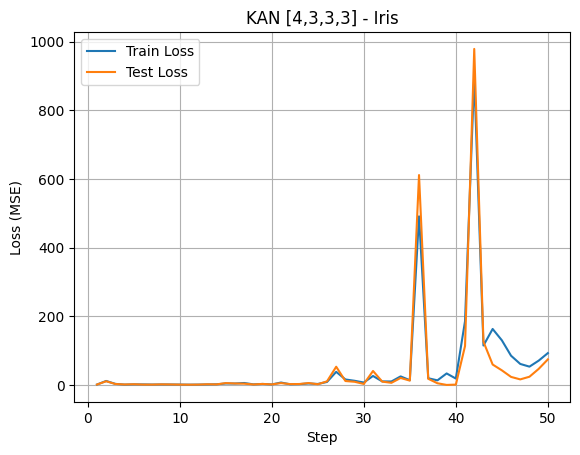

In [3]:
from kan import *
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Usando:", device)

# Dataset Iris
iris = load_iris()
X = iris.data  # 4 atributos
y = iris.target.reshape(-1, 1)  # Clases: 0,1,2

# Normalización y one-hot encoding
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y)

# División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.3, random_state=42)

# Conversión a tensores
dtype = torch.get_default_dtype()
dataset = {
    'train_input': torch.from_numpy(X_train).type(dtype).to(device),
    'test_input': torch.from_numpy(X_test).type(dtype).to(device),
    'train_label': torch.from_numpy(y_train).type(dtype).to(device),
    'test_label': torch.from_numpy(y_test).type(dtype).to(device)
}

# Definición del modelo KAN: arquitectura [4, 3, 3, 3]
model = KAN(width=[4, 3, 3, 3], grid=3, k=3, device=device)

# Métricas: usamos CrossEntropy efectiva para clasificación multiclase

# Convertir etiquetas one-hot a índices de clase
train_labels_int = torch.argmax(dataset['train_label'], dim=1)
test_labels_int = torch.argmax(dataset['test_label'], dim=1)

# Definir función de pérdida CrossEntropy
loss_fn = torch.nn.CrossEntropyLoss()

def train_loss():
    logits = model(dataset['train_input'])  # Sin softmax
    return loss_fn(logits, train_labels_int)

def test_loss():
    logits = model(dataset['test_input'])
    return loss_fn(logits, test_labels_int)

def train_acc():
    y_pred = model(dataset['train_input'])
    pred_class = torch.argmax(y_pred, dim=1)
    true_class = torch.argmax(dataset['train_label'], dim=1)
    return torch.mean((pred_class == true_class).float())

def test_acc():
    y_pred = model(dataset['test_input'])
    pred_class = torch.argmax(y_pred, dim=1)
    true_class = torch.argmax(dataset['test_label'], dim=1)
    return torch.mean((pred_class == true_class).float())


# Entrenamiento
steps = 50
results = model.fit(dataset, opt="Adam", steps=steps, metrics=(train_loss, test_loss, train_acc, test_acc))

print("train_loss:", len(results['train_loss']))
print("test_loss:", len(results['test_loss']))
print("train_acc:", len(results['train_acc']))
print("test_acc:", len(results['test_acc']))

loss_table = pd.DataFrame({
    'step': list(range(1, len(results['train_acc']) + 1)),
    'train_loss': results['train_loss'][::2],  # cada 2 pasos
    'test_loss': results['test_loss'][::2],
    'train_acc': results['train_acc'],
    'test_acc': results['test_acc']
})


# Guardar como CSV
loss_table.to_csv("Liu_KAN_iris_4-3-3-3.csv", index=False)
print("Resultados guardados en Liu_KAN_iris-4-3-3-3.csv")

# Gráfica de pérdidas
plt.plot(loss_table['step'], loss_table['train_loss'], label='Train Loss')
plt.plot(loss_table['step'], loss_table['test_loss'], label='Test Loss')
plt.xlabel("Step")
plt.ylabel("Loss (MSE)")
plt.title("KAN [4,3,3,3] - Iris")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
out = model(dataset['train_input'])
print(out[:5])
print("Suma por fila:", out[:5].sum(dim=1))


tensor([[  -2.7028, -145.7814,  -29.6219],
        [-137.1266,    6.1467, -130.3274],
        [-105.8371,    5.2789,  -92.7854],
        [ -68.1655,   55.7162,  -37.4941],
        [-129.7984,    2.8911, -122.3986]], grad_fn=<SliceBackward0>)
Suma por fila: tensor([-178.1061, -261.3073, -193.3436,  -49.9434, -249.3060],
       grad_fn=<SumBackward1>)
